<a href="https://colab.research.google.com/github/BaronVonBussin/Stuff/blob/main/Example_ClusterCompare_3Flavors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-5c2072b0039d>:122: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(
<ipython-input-1-5c2072b0039d>:131: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(
<ipython-input-1-5c2072b0039d>:140: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(



Clustering Analysis Summary:
------------------------------

KMEANS:
Number of clusters: 4
Points per cluster: {2: 355, 0: 285, 1: 232, 3: 228}

DBSCAN:
Number of clusters: 2
Points per cluster: {0: 856, 1: 213, -1: 31}

HIERARCHICAL:
Number of clusters: 4
Points per cluster: {3: 320, 0: 319, 2: 260, 1: 201}


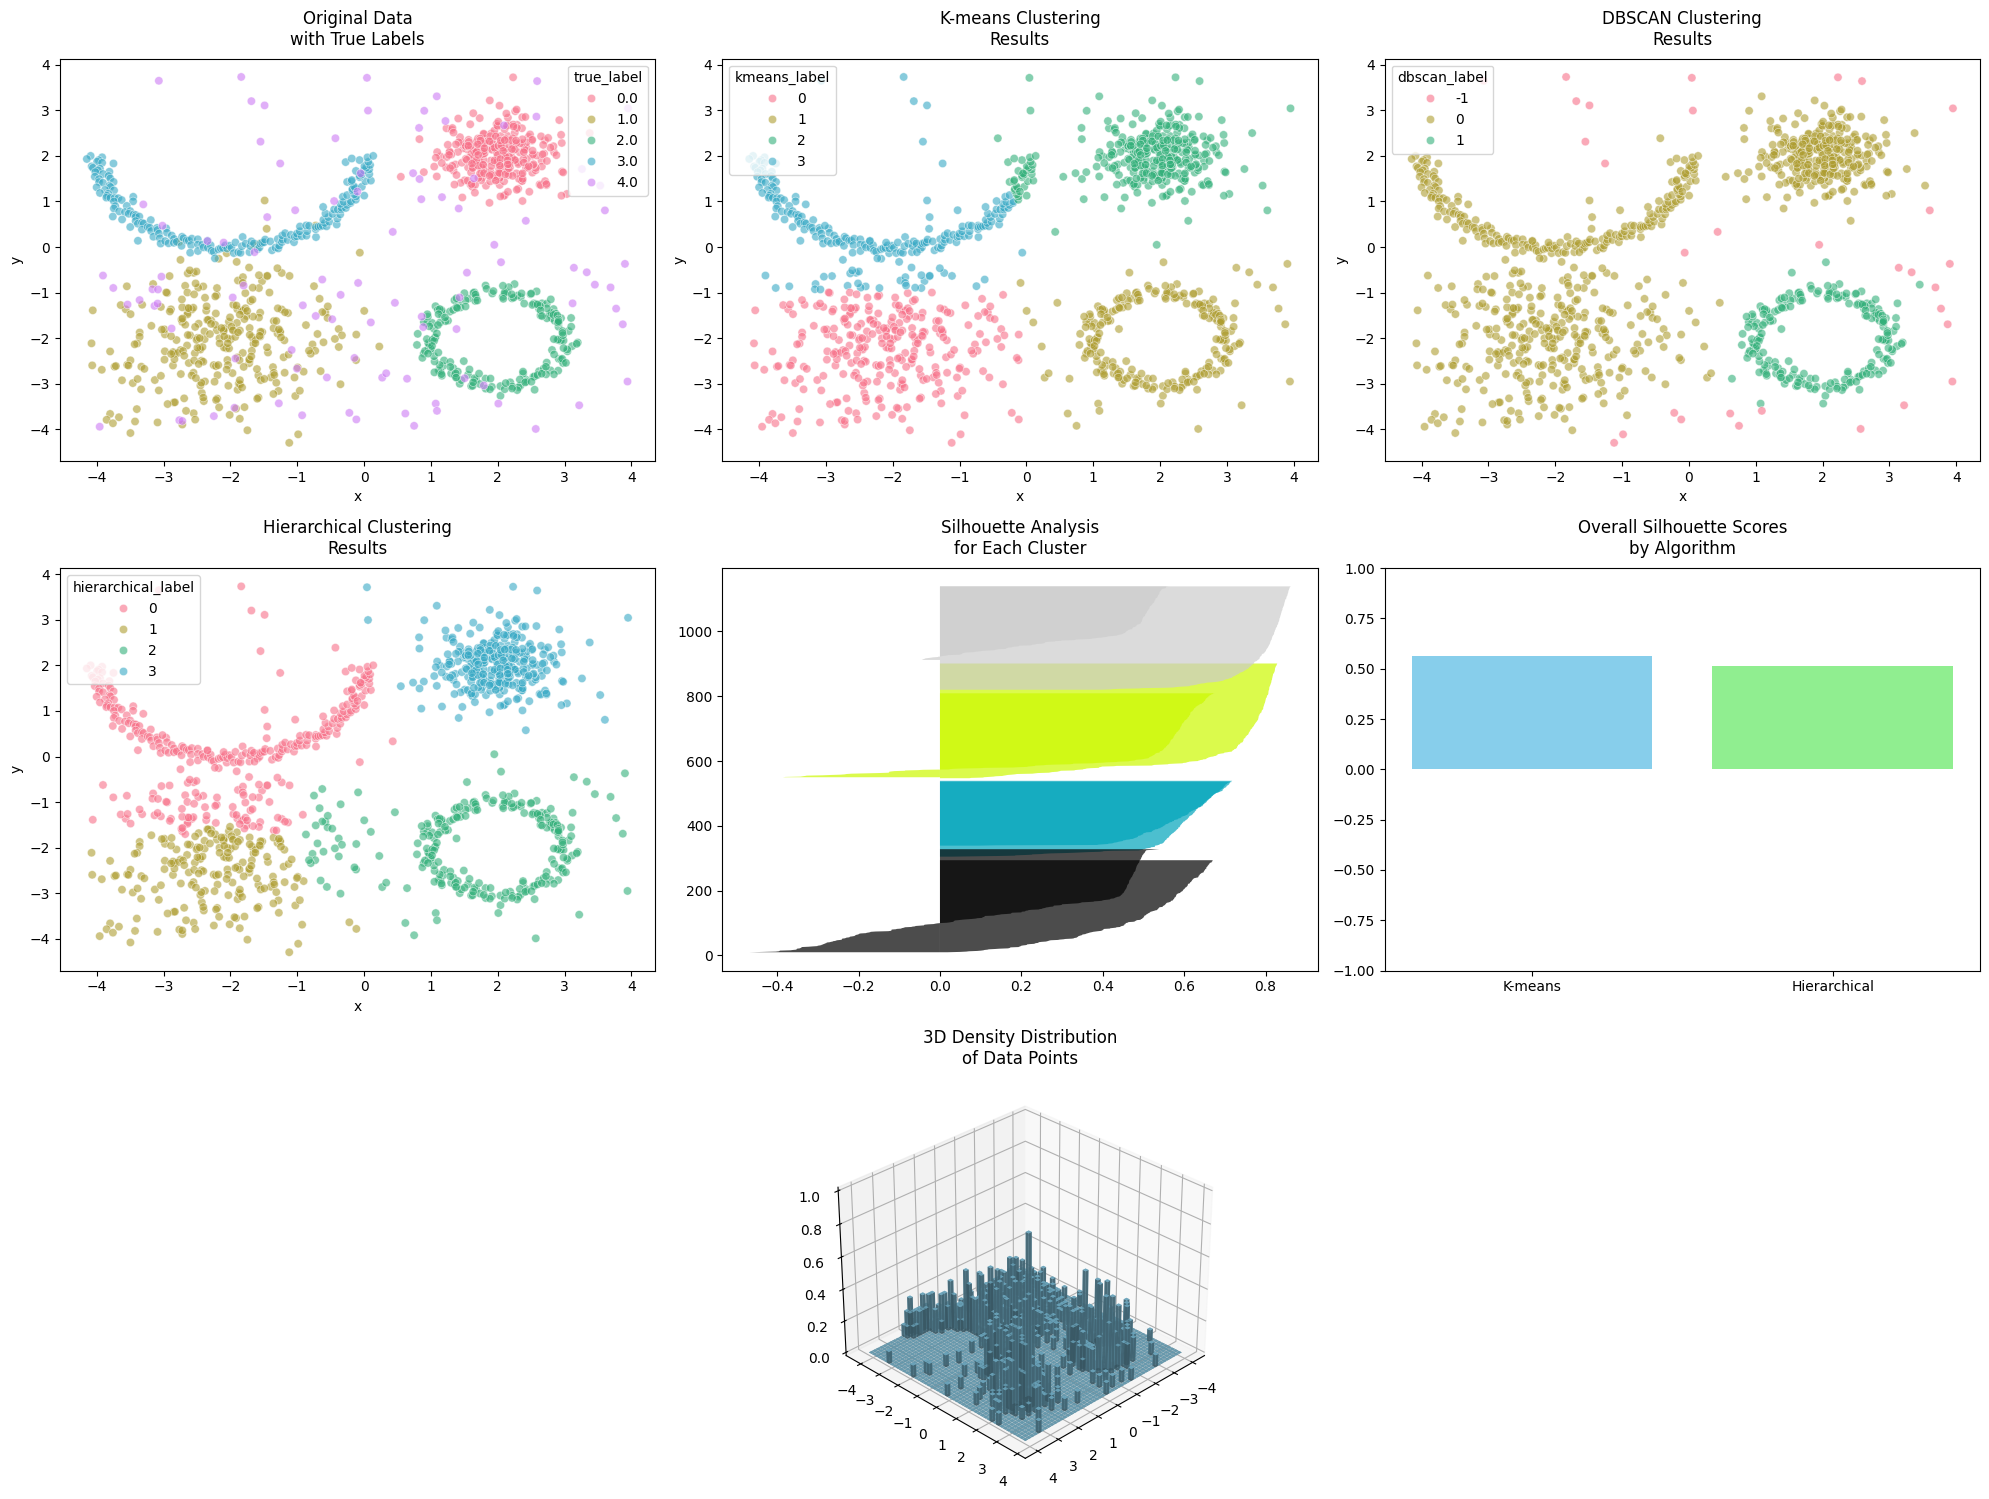

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

class ClusteringComparison:
    """
    A comprehensive clustering analysis system that compares K-means, DBSCAN,
    and Hierarchical clustering with detailed visualizations.
    """
    def __init__(self):
        self.scaler = StandardScaler()
        self.data = None
        self.scaled_data = None

    def generate_complex_dataset(self, n_samples=1000):
        """
        Generate a dataset that will challenge different clustering algorithms.
        Creates:
        - Two gaussian clusters (different densities)
        - One circular cluster
        - One moon-shaped cluster
        - Noise points
        """
        # Set random seed for reproducibility
        np.random.seed(42)

        # Generate gaussian clusters
        dense_gaussian = multivariate_normal.rvs(
            mean=[2, 2],
            cov=[[0.2, 0], [0, 0.2]],
            size=300
        )

        sparse_gaussian = multivariate_normal.rvs(
            mean=[-2, -2],
            cov=[[0.8, 0.2], [0.2, 0.8]],
            size=300
        )

        # Generate circular cluster
        theta = np.random.uniform(0, 2*np.pi, 200)
        r = np.random.normal(1, 0.1, 200)
        circular = np.column_stack([
            r * np.cos(theta) + 2,
            r * np.sin(theta) - 2
        ])

        # Generate moon-shaped cluster
        theta = np.linspace(-np.pi, 0, 200)
        r = 2 + np.random.normal(0, 0.1, 200)
        moon = np.column_stack([
            r * np.cos(theta) - 2,
            r * np.sin(theta) + 2
        ])

        # Generate noise points
        noise = np.random.uniform(-4, 4, (100, 2))

        # Combine all points
        X = np.vstack([dense_gaussian, sparse_gaussian, circular, moon, noise])

        # Create true labels (for reference)
        y = np.concatenate([
            np.zeros(300),    # dense gaussian
            np.ones(300),     # sparse gaussian
            2 * np.ones(200), # circular
            3 * np.ones(200), # moon
            4 * np.ones(100)  # noise
        ])

        self.data = pd.DataFrame(X, columns=['x', 'y'])
        self.data['true_label'] = y
        self.scaled_data = self.scaler.fit_transform(X)

        return self.data

    def apply_clustering(self):
        """
        Apply different clustering algorithms and store results.
        """
        # K-means clustering
        kmeans = KMeans(n_clusters=4, random_state=42)
        self.data['kmeans_label'] = kmeans.fit_predict(self.scaled_data)

        # DBSCAN clustering
        dbscan = DBSCAN(eps=0.3, min_samples=10)
        self.data['dbscan_label'] = dbscan.fit_predict(self.scaled_data)

        # Hierarchical clustering
        hierarchical = AgglomerativeClustering(n_clusters=4)
        self.data['hierarchical_label'] = hierarchical.fit_predict(self.scaled_data)

        return self.data

    def plot_clustering_comparison(self):
        """
        Create a comprehensive visualization comparing clustering results.
        """
        # Set up the matplotlib figure
        fig = plt.figure(figsize=(20, 15))
        gs = fig.add_gridspec(3, 3)

        # Define a custom color palette
        colors = sns.color_palette("husl", n_colors=5)

        # Plot original data
        ax1 = fig.add_subplot(gs[0, 0])
        sns.scatterplot(
            data=self.data, x='x', y='y',
            hue='true_label', palette=colors,
            alpha=0.6, ax=ax1
        )
        ax1.set_title('Original Data\nwith True Labels', fontsize=12, pad=10)

        # Plot K-means results
        ax2 = fig.add_subplot(gs[0, 1])
        sns.scatterplot(
            data=self.data, x='x', y='y',
            hue='kmeans_label', palette=colors,
            alpha=0.6, ax=ax2
        )
        ax2.set_title('K-means Clustering\nResults', fontsize=12, pad=10)

        # Plot DBSCAN results
        ax3 = fig.add_subplot(gs[0, 2])
        sns.scatterplot(
            data=self.data, x='x', y='y',
            hue='dbscan_label', palette=colors,
            alpha=0.6, ax=ax3
        )
        ax3.set_title('DBSCAN Clustering\nResults', fontsize=12, pad=10)

        # Plot Hierarchical results
        ax4 = fig.add_subplot(gs[1, 0])
        sns.scatterplot(
            data=self.data, x='x', y='y',
            hue='hierarchical_label', palette=colors,
            alpha=0.6, ax=ax4
        )
        ax4.set_title('Hierarchical Clustering\nResults', fontsize=12, pad=10)

        # Silhouette analysis plots
        self.plot_silhouette(ax5=fig.add_subplot(gs[1, 1]),
                            ax6=fig.add_subplot(gs[1, 2]))

        # 3D density plot
        ax7 = fig.add_subplot(gs[2, :], projection='3d')
        self.plot_3d_density(ax7)

        plt.tight_layout()
        return plt

    def plot_silhouette(self, ax5, ax6):
        """
        Create silhouette analysis plots.
        """
        # Calculate silhouette scores
        algorithms = ['kmeans_label', 'hierarchical_label']
        scores = []

        for algo in algorithms:
            # Skip clusters with label -1 (noise points in DBSCAN)
            mask = self.data[algo] != -1
            if mask.any():
                score = silhouette_score(
                    self.scaled_data[mask],
                    self.data[algo][mask]
                )
                scores.append(score)

                # Calculate silhouette values for each sample
                silhouette_vals = silhouette_samples(
                    self.scaled_data[mask],
                    self.data[algo][mask]
                )

                # Plot silhouette plots
                y_lower = 10
                for i in range(max(self.data[algo]) + 1):
                    ith_cluster_vals = silhouette_vals[self.data[algo][mask] == i]
                    ith_cluster_vals.sort()

                    y_upper = y_lower + len(ith_cluster_vals)

                    color = plt.cm.nipy_spectral(float(i) / max(self.data[algo]))
                    ax5.fill_betweenx(np.arange(y_lower, y_upper),
                                    0, ith_cluster_vals,
                                    facecolor=color, alpha=0.7)

                    y_lower = y_upper + 10

        ax5.set_title('Silhouette Analysis\nfor Each Cluster', fontsize=12, pad=10)

        # Bar plot of silhouette scores
        ax6.bar(['K-means', 'Hierarchical'], scores, color=['skyblue', 'lightgreen'])
        ax6.set_title('Overall Silhouette Scores\nby Algorithm', fontsize=12, pad=10)
        ax6.set_ylim(-1, 1)

    def plot_3d_density(self, ax):
        """
        Create a 3D density plot of the data.
        """
        # Calculate 2D histogram
        H, xedges, yedges = np.histogram2d(
            self.data['x'], self.data['y'],
            bins=50, density=True
        )

        # Create meshgrid for 3D plot
        xpos, ypos = np.meshgrid(
            (xedges[:-1] + xedges[1:])/2,
            (yedges[:-1] + yedges[1:])/2
        )

        xpos = xpos.flatten()
        ypos = ypos.flatten()
        zpos = 0

        dx = (xedges[1] - xedges[0]) * 0.9
        dy = (yedges[1] - yedges[0]) * 0.9
        dz = H.flatten()

        # Normalize heights for better visualization
        dz = dz/dz.max()

        # Create 3D bars
        ax.bar3d(xpos, ypos, zpos, dx, dy, dz,
                color='skyblue', alpha=0.8, zsort='average')

        ax.set_title('3D Density Distribution\nof Data Points',
                    fontsize=12, pad=10)

        # Adjust view angle for better visualization
        ax.view_init(elev=30, azim=45)

# Example usage
def main():
    # Initialize clustering comparison
    cc = ClusteringComparison()

    # Generate dataset
    data = cc.generate_complex_dataset()

    # Apply clustering
    results = cc.apply_clustering()

    # Create visualizations
    plt = cc.plot_clustering_comparison()

    # Print summary statistics
    print("\nClustering Analysis Summary:")
    print("-" * 30)

    for algo in ['kmeans_label', 'dbscan_label', 'hierarchical_label']:
        n_clusters = len(np.unique(results[algo]))
        if -1 in results[algo].unique():  # Account for noise in DBSCAN
            n_clusters -= 1
        print(f"\n{algo.split('_')[0].upper()}:")
        print(f"Number of clusters: {n_clusters}")
        print(f"Points per cluster: {results[algo].value_counts().to_dict()}")

    return results, plt

if __name__ == "__main__":
    results, plt = main()